$$
\textbf{Lógica Computacional: 2020/2021}\qquad
\textbf{Trabalho 1}\qquad
\scriptsize{Gilberto \, Cunha \quad Tomás \, Carneiro}
$$

# Problema 1

In [6]:
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import numpy as np
from z3 import *

In [2]:
def all_simple_edges(G_in, source,target):
    paths = list(nx.all_simple_paths(G_in, source=source, target=target))
    edges = [[(paths[i][j-1], paths[i][j]) for j in range(1, len(paths[i]))] for i in range(len(paths))]
    return edges

A um grafo de input conectado são acrescentados um número aleatório de descendentes a cada nodo, formando o grafo $G = \langle \mathcal{V}, \mathcal{E} \rangle$. Cada um destes descendentes tem um destino. Seja $\mathcal{D}$ o conjunto de pares de vértices descendente e destino.

Queremos determinar um subgrafo de $\mathcal{H = \langle \mathcal{V}, \mathcal{E'} \rangle}$, minimizando $|\mathcal{E'}|$ tal que este continue a ser conectado.

Ambos $G$ e $\mathcal{H}$ podem ser representados por uma matriz de arestas $A$ e $B$, respetivamente, onde os elementos $A_{ij}, B_{ij} \in \{0, 1\}$ representam a existência de uma aresta orientada do vértice $n_i$ ao vértice $n_j$.

1. Para uma dada aresta pertencer a $\mathcal{H}$, então também deve pertencer a $G$:

$$ \forall_{\langle n_i, n_j \rangle \in G}, \quad 0 \le B_{ij} \le A_{ij} $$

Para cada par de vértices $\langle n_i, n_j \rangle \in D$ existe um conjunto de caminhos sem loops $S \equiv \{S_k\}$ que liga $n_i$ a $n_j$. A função `all_simple_paths` da biblioteca `networkx` do python permite determinar este conjunto $S$.

Para um dado caminho $S_k$ existir, então:

$$\prod_{\langle n_w, n_z \rangle \in S_k} B_{w, z} = 1 $$

2. Existe sempre um caminho $S_k \in S$, com $S$ o conjunto de caminhos entre cada par de vértices descendente e destino $\langle n_i, n_j \rangle \in \mathcal{D}$:

$$ \forall_{\langle n_i, n_j \rangle \in \mathcal{D}}, \sum_{S_k \in S} \left( \prod_{\langle n_w, n_z \rangle \in S_k} B_{w, z} \right) \ge 1 $$

3. Devemos então minimizar o número de arestas em $\mathcal{H}$:

$$ minimize \sum_{i=0}^{V-1} \sum_{j=0}^{V-1} B_{ij} $$

## Gerar grafo $G$ aleatóriamente

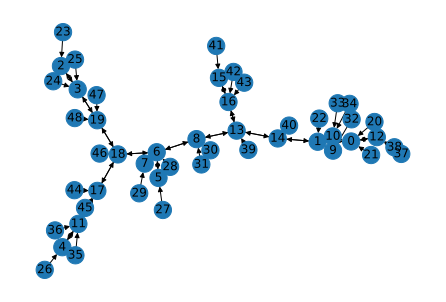

In [3]:
# Gerar o grafo aleatóriamente
n = 20
k = np.random.randint(2, 5)
p = np.random.random()
G = nx.connected_watts_strogatz_graph(n, 3, p)

# Tornar o grafo orientado
G = G.to_directed()

# Gerar um número de descendentes aleatório
d = 2
for i in range(n):
    num_desc = np.random.randint(1,d+1)
    destinos = [i for i in range(n)]
    for j in range(len(G.nodes), len(G.nodes)+num_desc):
        G.add_nodes_from([j])
        G.add_edges_from([(j,i)])
        G.nodes[j]["type"] = "desc"
        
        dest = np.random.randint(len(destinos))
        G.nodes[j]["dest"] = destinos[dest]
        destinos.remove(destinos[dest])

nx.draw(G, with_labels=True)

## Definir as condições que permitem deduzir $\mathcal{H}$ no Z3

In [4]:
def strongly_connected_subgraph(G_in):
    solver = Optimize()
    B = {(i, j): Int(f'{i},{j}') for i in range(len(G_in.nodes())) for j in range(len(G_in.nodes()))}
    
    # Pertence ao grafo original
    for i in range(len(G_in.nodes())):
        for j in range(len(G_in.nodes())):
            if (i,j) in G_in.edges:
                A_ij = 1
            else:
                A_ij = 0
            solver.add(B[i,j]>=0, B[i,j]<=A_ij)
            
    # Deve haver sempre um caminho entre um descendente e o seu destino
    for i in G_in.nodes:
        if "dest" in G_in.nodes[i]:
            j = G_in.nodes[i]["dest"]
            S = all_simple_edges(G_in, i, j)
            soma = Sum([Product([B[w,z] for (w,z) in S_k]) for S_k in S])
            solver.add(soma >= 1)

    # Minimizar o número de arestas
    obj = solver.minimize(Sum([B[i,j] for i in range(len(G_in.nodes())) for j in range(len(G_in.nodes()))]))

    # Verificar a satisfazibilidade
    if solver.check() == sat:
        print ("The maximum number of removable edges is", len(G_in.edges) - int(str(solver.lower(obj))))
        m = solver.model()
        rem_edges = [(i,j) for i,j in G_in.edges if m[B[i,j]]==0]
        r = nx.DiGraph.copy(G_in)
        r.remove_edges_from(rem_edges)
    else:
        r = None
        
    return r

## Determinar a solução $\mathcal{H}$

In [8]:
H = strongly_connected_subgraph(G)

# Verificar que não existe nenhuma aresta em H que não exista em G
count = sum([1 for edge in H.edges if edge not in G.edges])
if count >= 1:
    print ("\nThere are edges in H that are not present in G")
else:
    print ("\nAll edges in H are present in G")
    
# Verificar que G e H têm o mesmo número de nodos
if len(H.nodes) == len(G.nodes):
    print ("G and H have the same number of nodes\n")
else:
    print ("G and H do not have the same number of nodes\n")
    
# Verificar que não pode ser removida nenhuma aresta
edges = list(H.edges)
for i, j in tqdm(edges, total=len(edges), desc=f"Checking for removable edges"):
    H.remove_edges_from([(i,j)])
    assert strongly_connected_subgraph(H) == None
    H.add_edges_from([(i,j)])
print ("No edge can be removed from the graph!")

Checking for removable edges::   0%|          | 0/64 [00:00<?, ?it/s]

The maximum number of removable edges is 5

All edges in H are present in G
G and H have the same number of nodes



Checking for removable edges:: 100%|██████████| 64/64 [00:26<00:00,  2.41it/s]

No edge can be removed from the graph!


## Dar plot ao grafo $G$ e das arestas removidas

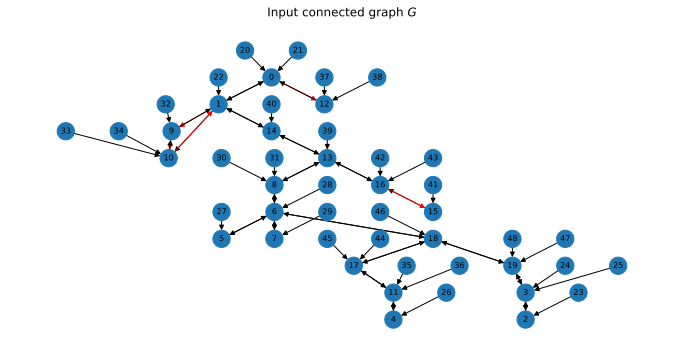

In [12]:
f = plt.figure(figsize=(12, 6))

# Pintar as arestas removidas a vermelho
edge_colors = []
for edge in G.edges:
    if edge not in H.edges:
        edge_colors.append("red")
    else:
        edge_colors.append("black")

# Plot do grafo de input
plt.title("Input connected graph $G$")
pos = nx.nx_pydot.graphviz_layout(G)
pos = nx.nx_pydot.graphviz_layout(G, prog="dot")

nx.draw(G, font_size=8, pos=pos, edge_color=edge_colors, with_labels=True)
plt.show()

## Dar plot a um caminho entre um par aleatório $\langle n_i, n_j \rangle$

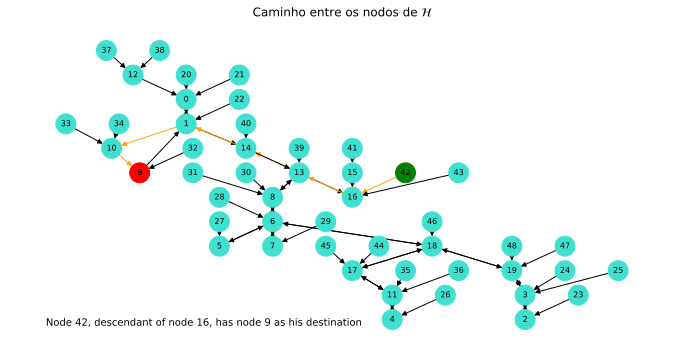

In [11]:
f = plt.figure(figsize=(12, 6))

# Gerar um par de nodos aleatóriamente
i = np.random.randint(n, len(G.nodes))
j = H.nodes[i]["dest"]
k = list(H.neighbors(i))[0]

# Pintar as arestas desse caminho a laranja
path = all_simple_edges(H, i, j)[0]
edge_colors = []
for edge in H.edges:
    if edge in path:
        edge_colors.append("orange")
    else:
        edge_colors.append("black")
        
# Pintar o nodo inicial de verde e o nodo final de vermelho
node_colors = []
for node in H.nodes:
    if node == i:
        node_colors.append("green")
    elif node == j:
        node_colors.append("red")
    else:
        node_colors.append("turquoise")
        
# Plot do grafo de input
plt.title("Caminho entre os nodos de $\mathcal{H}$")
pos = nx.nx_pydot.graphviz_layout(H)
pos = nx.nx_pydot.graphviz_layout(H, prog="dot")
nx.draw(H, font_size=8, node_size=4e2, pos=pos, with_labels=True, edge_color=edge_colors,
        node_color=node_colors)
plt.text(0, 0, f"Node {i}, descendant of node {k}, has node {j} as his destination")
plt.show()